# Inverted Pendulum Problem

The state and control vectors $\textbf{x}$ and $\textbf{u}$ are defined as follows:

$$
\begin{equation*}
\textbf{x} = \begin{bmatrix}
    \theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

$$
\begin{equation*}
\textbf{u} = \begin{bmatrix}
    \tau
    \end{bmatrix}
\end{equation*}
$$

The goal is to swing the pendulum upright:

$$
\begin{equation*}
\textbf{x}_{goal} = \begin{bmatrix}
    0 & 0
    \end{bmatrix}
\end{equation*}
$$

In order to deal with potential angle wrap-around issues (i.e. $2\pi = 0$), we
augment the state as follows and use that instead:

$$
\begin{equation*}
\textbf{x}_{augmented} = \begin{bmatrix}
    \sin\theta & \cos\theta & \dot{\theta}
    \end{bmatrix}
\end{equation*}
$$

**Note**: The torque is constrained between $-1$ and $1$. This is achieved by
instead fitting for unconstrained actions and then applying it to a squashing
function $\tanh(\textbf{u})$. This is directly embedded into the dynamics model
in order to be auto-differentiated. This also means that we need to apply this
transformation manually to the output of our iLQR at the end.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
from ilqr import iLQR
from ilqr.cost import QRCost
from ilqr.dynamics import constrain
from ilqr.examples.pendulum import InvertedPendulumDynamics

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = dynamics.reduce_state(xs[-1])
    print("iteration", iteration_count, info, J_opt, final_state)

In [6]:
dt = 0.02
pendulum_length = 1.0
dynamics = InvertedPendulumDynamics(dt, l=pendulum_length)

In [7]:
# Note that the augmented state is not all 0.
x_goal = dynamics.augment_state(np.array([0.0, 0.0]))
Q = np.eye(dynamics.state_size)
Q[0, 1] = Q[1, 0] = pendulum_length
Q[0, 0] = Q[1, 1] = pendulum_length**2
Q[2, 2] = 0.0
Q_terminal = 100 * np.eye(dynamics.state_size)
R = np.array([[0.1]])
cost = QRCost(Q, R, Q_terminal=Q_terminal, x_goal=x_goal)

In [8]:
N = 30
x0 = dynamics.augment_state(np.array([np.pi, 0.0]))
us_init = np.random.uniform(-1, 1, (N, dynamics.action_size))
ilqr = iLQR(dynamics, cost, N)

In [9]:
J_hist = []
xs, us = ilqr.fit(x0, us_init, n_iterations=200, on_iteration=on_iteration)

iteration 0 accepted 509.3296129903746 [2.9672769  0.01163358]
iteration 1 accepted 507.83785748285027 [ 2.89149421 -0.00379308]
iteration 2 accepted 503.35784953875066 [ 2.85903849 -0.00945641]
iteration 3 accepted 502.26449362509993 [ 2.85719146 -0.0207078 ]
iteration 4 accepted 502.2182465063114 [ 2.85623385 -0.02499783]
iteration 5 accepted 502.20151179621274 [ 2.85597521 -0.02768767]
iteration 6 accepted 502.1951511166035 [ 2.85559511 -0.02913052]
iteration 7 accepted 502.19237752321754 [ 2.85557139 -0.03005608]
iteration 8 accepted 502.1912243769877 [ 2.85543263 -0.030536  ]
iteration 9 accepted 502.1906998456487 [ 2.85544019 -0.03085351]
iteration 10 converged 502.19046910984696 [ 2.85538632 -0.03101173]


In [10]:
# Reduce the state to something more reasonable.
xs = dynamics.reduce_state(xs)

# Constrain the actions to see what's actually applied to the system.
us = constrain(us, dynamics.min_bounds, dynamics.max_bounds)

In [11]:
t = np.arange(N) * dt
theta = np.unwrap(xs[:, 0])  # Makes for smoother plots.
theta_dot = xs[:, 1]

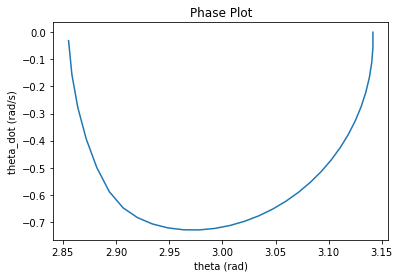

In [12]:
_ = plt.plot(theta, theta_dot)
_ = plt.xlabel("theta (rad)")
_ = plt.ylabel("theta_dot (rad/s)")
_ = plt.title("Phase Plot")

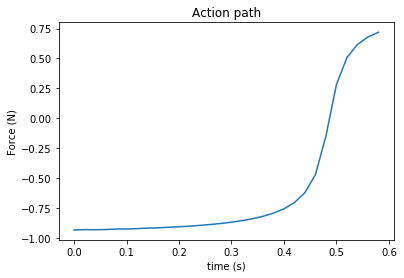

In [13]:
_ = plt.plot(t, us)
_ = plt.xlabel("time (s)")
_ = plt.ylabel("Force (N)")
_ = plt.title("Action path")

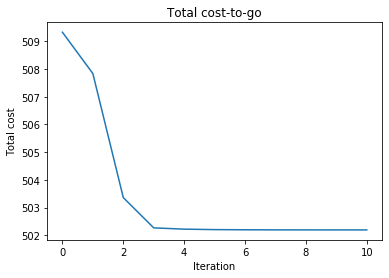

In [14]:
_ = plt.plot(J_hist)
_ = plt.xlabel("Iteration")
_ = plt.ylabel("Total cost")
_ = plt.title("Total cost-to-go")